# 데이터 준비

In [1]:
import os
import random
import numpy as np

import nltk

nltk.download("punkt")
from nltk.tokenize import word_tokenize

import torch

from torchtext.legacy.data import Field
from torchtext.legacy.data import TabularDataset
from torchtext.legacy.data import BucketIterator
from torchtext.legacy.data import Iterator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Nondeterministic 한 작업 피하기
RANDOM_SEED = 2022

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True   # Deterministic 한 알고리즘만 사용하기
torch.backends.cudnn.benchmark = False      # Cudnn benchmark 해제
torch.cuda.manual_seed_all(RANDOM_SEED)     # if use multi-GPU

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [3]:
DATA_PATH = "/content/drive/Othercomputers/내 컴퓨터/Sat_english/data/processed"

필드 정의

In [4]:
# 문장 필드
TEXT = Field(
    sequential=True,    # 문장 입력
    use_vocab=True,     
    tokenize=word_tokenize,     # nltk의 word_tokenize로 트큰화
    lower=True,         # 모두 소문자 처리
    batch_first=True,
)

# 정답 필드
LABEL = Field(
    sequential=False,
    use_vocab=False,
    batch_first=True,
)

데이터 불러오기

In [5]:
# CoLA 데이터 = 사전 학습 데이터
cola_train_data, cola_valid_data, cola_test_data = TabularDataset.splits(
    path=DATA_PATH,
    train="cola_train.tsv",
    validation="cola_valid.tsv",
    test="cola_test.tsv",
    format="tsv",
    fields=[("text", TEXT), ("label", LABEL)],
    skip_header=1,          # column명이 있는 1열 생략
)

TEXT.build_vocab(cola_train_data, min_freq=2)   # CoLA 데이터로 사전학습할 단어장 생성(2번 이상 나온 단어만)

# 수능 데이터 = 추가 학습 데이터
sat_train_data, sat_valid_data, sat_test_data = TabularDataset.splits(
    path=DATA_PATH,
    train="sat_train.tsv",
    validation="sat_valid.tsv",
    test="sat_test.tsv",
    format="tsv",
    fields=[("text", TEXT), ("label", LABEL)],
    skip_header=1,
)

DataLoader 정의

In [6]:
# CoLA 데이터
cola_train_iterator, cola_valid_iterator, cola_test_iterator = BucketIterator.splits(
    (cola_train_data, cola_valid_data, cola_test_data),
    batch_size=32,
    device=None,
    sort=False,
)

# 수능 데이터
sat_train_iterator, sat_valid_iterator, sat_test_iterator = BucketIterator.splits(
    (sat_train_data, sat_valid_data, sat_test_data),
    batch_size=8,
    device=None,
    sort=False,
)

# 네트워크 구성

In [7]:
import torch
import torch.nn as nn

In [8]:
class LSTM_Pooling_Model(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, pad_idx):
        super().__init__()

        # Embedding Layer
        self.embed_layer = nn.Embedding(
                num_embeddings=num_embeddings,
                embedding_dim=embedding_dim,
                padding_idx=pad_idx
            )
        
        # LSTM Layer
        self.lstm_layer = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            bidirectional=True,     # 양방향 LSTM
            batch_first=True,       
            dropout=0.5     
        )

        # Fully-connetcted Layer
        self.fc_layer = nn.Sequential(
            nn.Linear(hidden_size*2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embed_layer(x)

        output, _ = self.lstm_layer(x)

        pool = nn.functional.max_pool1d(output.transpose(1, 2), x.shape[1])
        pool = pool.transpose(1, 2).squeeze()
        pool = nn.functional.dropout(pool, p=0.5)

        output = self.fc_layer(pool)

        return output.squeeze()

# 모델 학습 및 검증

파라미터 정의

In [9]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")    # GPU 존재시 GPU 실행(CUDA)
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]       # 동일한 크기를 맞추기 위한 패딩문자를 숫자 식별자에 매칭 -> 숫자 식별자=index

lstm_pooling = LSTM_Pooling_Model(
        num_embeddings=len(TEXT.vocab),
        embedding_dim=100,
        hidden_size=200,
        num_layers=4,
        pad_idx=PAD_IDX
    ).to(DEVICE)

n_epochs = 20
learning_rate = 0.001

optimizer = torch.optim.Adam(lstm_pooling.parameters(), lr=learning_rate)
criterion = nn.BCELoss()  # BCELoss

훈련 데이터로 학습하여 모델화

In [10]:
def train(model, iterator, optimizer):
    train_loss = 0

    model.train()       # 모델을 train모드로 설정(Dropout 적용)
    for _, batch in enumerate(iterator):
        optimizer.zero_grad()   # optimizer 초기화(Gradient)

        text = batch.text      # 해당 Batch의 text 속성 불러오기
        label = batch.label.type(torch.FloatTensor)     # 해당 Batch의 label 속성 불러오기(32-bit float)

        text = text.to(DEVICE)
        label = label.to(DEVICE)

        output = model(text).flatten()        # output은 [batch_size, 1], label은 [batch_size]
        loss = criterion(output, label)
        loss.backward()     # 역전파로 Gradient를 계산 후 파라미터에 할당
        optimizer.step()    # 파라미터 업데이트

        train_loss += loss.item()   # Loss 값 누적

    # Loss 값을 Batch 값으로 나누어 미니 배치마다의 Loss 값의 평균을 구함
    return train_loss/len(iterator)

모델 검증

In [11]:
def evaluate(model, iterator):
    valid_loss = 0

    model.eval()        # 모델을 eval모드로 설정(Dropout 미적용)
    with torch.no_grad():       # Gradient 계산 비활성화 (모델 평가에는 파라미터 업데이트 X)
        for _, batch in enumerate(iterator):
            text = batch.text
            label = batch.label.type(torch.FloatTensor)

            text = text.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(text).flatten()
            loss = criterion(output, label)

            valid_loss += loss.item()

    return valid_loss/len(iterator)

CoLA 데이터 사전학습

In [12]:
import time

In [13]:
def epoch_time(start_time: int, end_time: int):     # epoch 시간
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
loss_tr = []
loss_val = []

In [15]:
for epoch in range(n_epochs):

    start_time = time.time()

    train_loss = train(lstm_pooling, cola_train_iterator, optimizer)
    valid_loss = evaluate(lstm_pooling, cola_valid_iterator)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"Train Loss: {train_loss:.5f}")
    print(f" Val. Loss: {valid_loss:.5f}")
    print('----------------------------------')

    # overfitting 확인하기 위함
    loss_tr.append(train_loss)
    loss_val.append(valid_loss)

Epoch: 01 | Time: 0m 7s
Train Loss: 0.61027
 Val. Loss: 0.59394
----------------------------------
Epoch: 02 | Time: 0m 3s
Train Loss: 0.59450
 Val. Loss: 0.59299
----------------------------------
Epoch: 03 | Time: 0m 3s
Train Loss: 0.56691
 Val. Loss: 0.60837
----------------------------------
Epoch: 04 | Time: 0m 3s
Train Loss: 0.52779
 Val. Loss: 0.62392
----------------------------------
Epoch: 05 | Time: 0m 3s
Train Loss: 0.47437
 Val. Loss: 0.66978
----------------------------------
Epoch: 06 | Time: 0m 3s
Train Loss: 0.41387
 Val. Loss: 0.74521
----------------------------------
Epoch: 07 | Time: 0m 3s
Train Loss: 0.35504
 Val. Loss: 0.83564
----------------------------------
Epoch: 08 | Time: 0m 3s
Train Loss: 0.28674
 Val. Loss: 0.88789
----------------------------------
Epoch: 09 | Time: 0m 3s
Train Loss: 0.23355
 Val. Loss: 1.01798
----------------------------------
Epoch: 10 | Time: 0m 3s
Train Loss: 0.19262
 Val. Loss: 1.11603
----------------------------------
Epoch: 11 

In [16]:
import numpy as np
import matplotlib.pyplot as plt

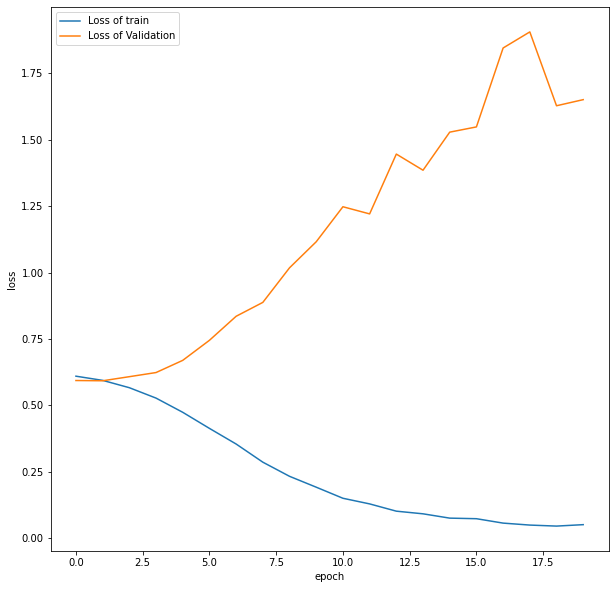

In [17]:
np1 = np.array(loss_tr)
np2 = np.array(loss_val)

plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(np1, label='Loss of train')
plt.plot(np2, label='Loss of Validation')
plt.legend()  # 라벨표시를 위한 범례

plt.show()

In [18]:
from copy import deepcopy

# 사전학습 모델
before_tuning_lstm_pooling = deepcopy(lstm_pooling)

수능 데이터를 이용해 추가 학습 (Fine-Tune)

In [19]:
loss_tr_tune = []
loss_val_tune = []

for epoch in range(n_epochs):

    start_time = time.time()

    train_loss = train(lstm_pooling, sat_train_iterator, optimizer)
    valid_loss = evaluate(lstm_pooling, sat_valid_iterator)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")
    print('----------------------------------')

    # overfitting 확인하기 위함
    loss_tr_tune.append(train_loss)
    loss_val_tune.append(valid_loss)

Epoch: 01 | Time: 0m 0s
	Train Loss: 0.79039
	 Val. Loss: 0.52839
----------------------------------
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.39479
	 Val. Loss: 0.56298
----------------------------------
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.36517
	 Val. Loss: 0.56907
----------------------------------
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.29952
	 Val. Loss: 0.69191
----------------------------------
Epoch: 05 | Time: 0m 0s
	Train Loss: 0.25820
	 Val. Loss: 0.68143
----------------------------------
Epoch: 06 | Time: 0m 0s
	Train Loss: 0.16699
	 Val. Loss: 0.66935
----------------------------------
Epoch: 07 | Time: 0m 0s
	Train Loss: 0.17218
	 Val. Loss: 1.13069
----------------------------------
Epoch: 08 | Time: 0m 0s
	Train Loss: 0.14202
	 Val. Loss: 0.72847
----------------------------------
Epoch: 09 | Time: 0m 0s
	Train Loss: 0.16009
	 Val. Loss: 0.83730
----------------------------------
Epoch: 10 | Time: 0m 0s
	Train Loss: 0.08591
	 Val. Loss: 0.84643
-------------------------

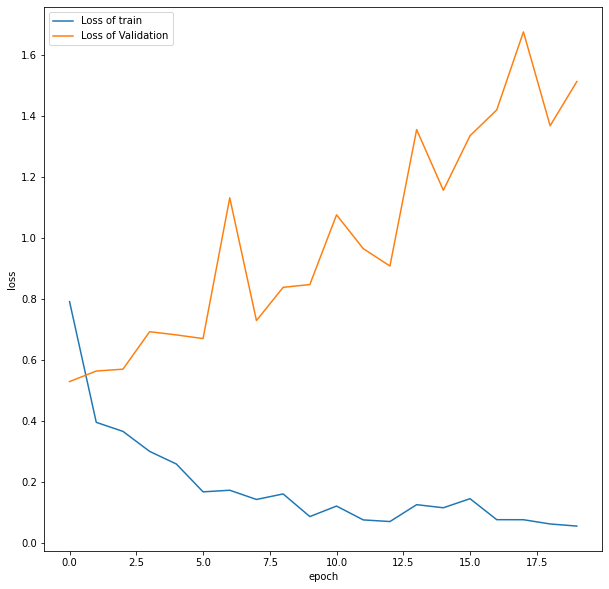

In [20]:
np1 = np.array(loss_tr_tune)
np2 = np.array(loss_val_tune)

plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(np1, label='Loss of train')
plt.plot(np2, label='Loss of Validation')
plt.legend()  # 라벨표시를 위한 범례

plt.show()

# 모델 성능 테스트

In [21]:
import dill

from sklearn.metrics import roc_curve, auc

In [22]:
def test(model, iterator, device):
    model.eval()
    with torch.no_grad():
        y_real = []
        y_pred = []

        for batch in iterator:
            text = batch.text
            label = batch.label.type(torch.FloatTensor)
            text = text.to(device)

            output = model(text).flatten().cpu()    # roc_curve의 입력 형태는 ndarray의 형태

            # 각 Batch의 예측값 list화
            y_real += [label]
            y_pred += [output]

        y_real = torch.cat(y_real)
        y_pred = torch.cat(y_pred)

    fpr, tpr, _ = roc_curve(y_real, y_pred)
    auroc = auc(fpr, tpr)

    return auroc

In [28]:
_ = before_tuning_lstm_pooling.cpu()
lstm_sat_test_auroc = test(before_tuning_lstm_pooling, sat_test_iterator, "cpu")

_ = lstm_pooling.cpu()
lstm_tuned_test_auroc = test(lstm_pooling, sat_test_iterator, "cpu")

print(f"Before fine-tuning SAT Dataset Test AUROC: {lstm_sat_test_auroc:.5f}")
print(f"After fine-tuning SAT Dataset Test AUROC: {lstm_tuned_test_auroc:.5f}")

Before fine-tuning SAT Dataset Test AUROC: 0.76923
After fine-tuning SAT Dataset Test AUROC: 0.84615


In [29]:
with open("advanced_before_tuning_model.dill", "wb") as f:
    model = {
        "TEXT": TEXT,
        "LABEL": LABEL,
        "classifier": before_tuning_lstm_pooling
    }
    dill.dump(model, f)

_ = lstm_pooling.cpu()
with open("advanced_after_tuning_model.dill", "wb") as f:
    model = {
        "TEXT": TEXT,
        "LABEL": LABEL,
        "classifier": lstm_pooling
    }
    dill.dump(model, f)